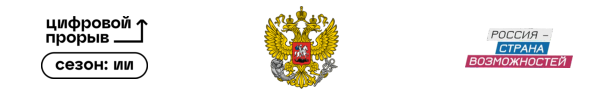
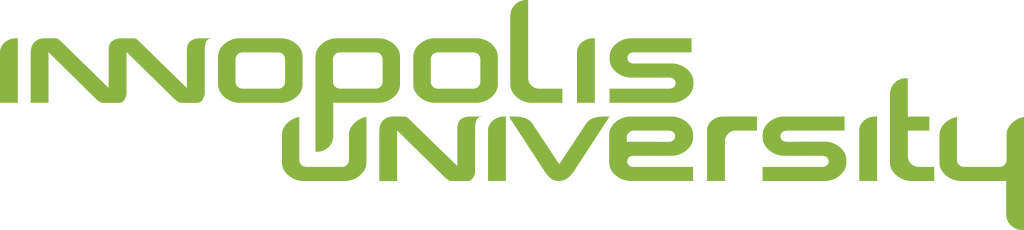

# «Классификация агрокультур на основе изменения показателя вегетационных индексов во временной последовательности»


Данные дистанционного зондирования Земли из космоса позволяют решать большое количество производственных задач.
Например, определять культуры растений на основе анализа временных рядов значений вегетационных индексов (NDVI), получаемых на протяжении вегетационного периода (периода роста и развития растений).
- NDVI – это индекс, определяемый по поглощению и отражению растениями лучей красной и ближней инфракрасной зоны спектра при анализе изображений космоснимков. По значению этого индекса можно судить о развитии зеленой массы растений во время вегетации. Чем больше зеленой биомассы на полях, тем выше значение NDVI.

Общая посевная площадь в России в 2022 году составила более 81 млн га. Для грамотного планирования сельскохозяйственного производства в масштабах страны, применения технологий точного земледелия, проведения мероприятий по защите растений, оценки урожайности критически важным является распознавание культур растений, произрастающих на каждом конкретном поле.

## Условие задачи

Разработать модель машинного обучения по классификации агрокультур на основе изменения показателя вегетационных индексов (NDVI) во временной последовательности.

Созданная модель поможет оптимизировать рабочие процессы в сфере сельского хозяйства, обеспечить органы власти актуальными и  достоверными сведениями, увеличить социальный, инвестиционный и производственный потенциал отрасли, а также повысить достоверность и удобство использования информации о сельскохозяйственных объектах.

### Описание входных значений

- train.csv — файл, содержащий данные о поле и временные ряды
- test.csv — файл, содержащий данные для предсказания
- sample_solution.csv — пример файла для отправки

### Пояснения к столбцам
- id – идентификатор объекта (поля)
- area – площадь поля в га
- nd mean YYYY-MM-DD – медианное значение вегетационного индекса NDVI для данного поля на указанную дату
- geo – координаты границ поля
- crop – столбец для предсказания, содержит тип произрастающей культуры по данным сельхозтоваропроизводителей

### Типы культур:
- 0 - подсолнечник
- 1 - картофель
- 2 - пшеница озимая
- 3 - гречиха
- 4 - кукуруза
- 5 - пшеница яровая
- 6 - сахарная свекла

## Этапы реализации
1. Обзор и предварительный анализ данных
2. Исследовательский анализ данных и предобработка
3. Модель и кросс-валидация
4. Подготовка ответа по тестовой выборке
5. Выводы по работе с данными

# 1. Обзор и предварительный анализ данных 

In [1]:
import time # импортируем все необходимые библиотеки и модули
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display # импортируем метод дисплей для вывода таблиц
pd.set_option('display.max_columns', None) # реализуем возможность вывода всех столбцов на экран
pd.set_option('display.float_format', '{:.3f}'.format) # еализуем возможность вывода значений float до 3 знаков после запятой

from sklearn.metrics import recall_score, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df_train = pd.read_csv('train.csv') # загружаем данные из файлов в датафреймы
df_test = pd.read_csv('test.csv')

In [3]:
display(df_train) # смотрим записи в датафрейме
display(df_train.info()) # смотрим общую информации по датафрейму
display(df_train.describe()) # смотрим общее описание датафрейма

,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,nd_mean_2021-05-16,nd_mean_2021-05-17,nd_mean_2021-05-21,nd_mean_2021-05-26,nd_mean_2021-05-27,nd_mean_2021-05-29,nd_mean_2021-06-06,nd_mean_2021-06-09,nd_mean_2021-06-13,nd_mean_2021-06-16,nd_mean_2021-06-18,nd_mean_2021-06-19,nd_mean_2021-06-20,nd_mean_2021-06-22,nd_mean_2021-06-25,nd_mean_2021-06-27,nd_mean_2021-07-07,nd_mean_2021-07-08,nd_mean_2021-07-09,nd_mean_2021-07-13,nd_mean_2021-07-15,nd_mean_2021-07-17,nd_mean_2021-07-20,nd_mean_2021-07-26,nd_mean_2021-07-27,nd_mean_2021-07-29,nd_mean_2021-07-31,nd_mean_2021-08-07,nd_mean_2021-08-12,.geo,nd_mean_2021-04-15,nd_mean_2021-04-18,nd_mean_2021-04-25,nd_mean_2021-04-27,nd_mean_2021-04-29,nd_mean_2021-04-30,nd_mean_2021-06-07,nd_mean_2021-06-12,nd_mean_2021-06-28,nd_mean_2021-08-01,nd_mean_2021-08-11,nd_mean_2021-05-01,nd_mean_2021-05-03,nd_mean_2021-05-10,nd_mean_2021-05-15,nd_mean_2021-06-02,nd_mean_2021-06-03,nd_mean_2021-07-04,nd_mean_2021-08-10,nd_mean_2021-08-23,nd_mean_2021-04-20,nd_mean_2021-04-23,nd_mean_2021-05-09,nd_mean_2021-05-19,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,crop
0,3536,20,0.073,0.262,0.063,0.104,0.021,0.052,0.159,0.000,0.484,0.201,0.030,0.398,0.385,0.016,0.007,0.442,0.173,0.000,0.412,0.507,0.491,0.550,0.461,0.101,0.707,0.691,0.711,0.731,0.718,0.000,0.147,0.728,0.113,0.728,0.000,0.000,0.658,"{""type"":""Polygon"",""coordinates"":[[[42.49107269...",0.187,0.262,0.078,0.000,0.000,0.000,0.112,0.039,0.155,0.755,0.000,0.122,0.084,0.213,0.358,0.271,0.174,0.014,0.031,0.035,0.063,0.000,0.103,0.426,0.109,0.119,0.000,0.000,0.027,0.127,0.615,0.009,0.081,3
1,3739,45,0.333,0.287,0.097,0.152,0.075,0.000,0.140,0.163,0.519,0.501,0.047,0.449,0.693,0.628,0.017,0.000,0.060,0.000,0.492,0.709,0.668,0.676,0.694,0.655,0.709,0.697,0.269,0.077,0.639,0.677,0.461,0.060,0.074,0.667,0.090,0.184,0.602,"{""type"":""Polygon"",""coordinates"":[[[50.25545110...",0.245,0.349,0.174,0.196,0.015,0.242,0.708,0.150,0.433,0.706,0.618,0.047,0.000,0.161,0.031,0.000,0.040,0.194,0.063,0.000,0.065,0.025,0.000,0.249,0.134,0.208,0.000,0.000,0.111,0.175,0.180,0.113,0.047,4
2,1294,28,0.014,0.007,0.121,0.038,0.259,0.000,0.037,0.507,0.000,0.562,0.000,0.030,0.246,0.650,0.000,0.516,0.000,0.717,0.649,0.741,0.652,0.740,0.595,0.741,0.648,0.242,0.586,0.551,0.523,0.543,0.000,0.173,0.119,0.322,0.411,0.357,0.000,"{""type"":""Polygon"",""coordinates"":[[[37.99698998...",0.006,0.000,0.042,0.169,0.011,0.118,0.056,0.012,0.172,0.000,0.172,0.230,0.025,0.152,0.003,0.012,0.000,0.136,0.045,0.000,0.000,0.112,0.029,0.128,0.084,0.000,0.210,0.130,0.155,0.091,0.054,0.007,0.220,2
3,2859,19,0.106,0.053,0.002,0.012,0.042,0.000,0.000,0.044,0.510,0.512,0.000,0.525,0.707,0.645,0.753,0.000,0.032,0.065,0.544,0.706,0.617,0.713,0.628,0.563,0.591,0.557,0.188,0.466,0.162,0.426,0.095,0.474,0.242,0.000,0.056,0.061,0.327,"{""type"":""Polygon"",""coordinates"":[[[44.72154181...",0.293,0.318,0.073,0.000,0.145,0.008,0.009,0.100,0.230,0.152,0.379,0.046,0.063,0.099,0.412,0.442,0.747,0.057,0.353,0.062,0.154,0.045,0.053,0.528,0.000,0.642,0.133,0.000,0.571,0.073,0.379,0.328,0.587,5
4,3685,33,0.131,0.063,0.024,0.000,0.151,0.047,0.254,0.101,0.000,0.403,0.243,0.509,0.244,0.085,0.025,0.020,0.174,0.242,0.583,0.454,0.587,0.573,0.602,0.172,0.752,0.726,0.751,0.767,0.191,0.783,0.518,0.803,0.762,0.834,0.611,0.000,0.055,"{""type"":""Polygon"",""coordinates"":[[[34.77829934...",0.028,0.117,0.109,0.022,0.034,0.081,0.240,0.022,0.087,0.773,0.000,0.149,0.047,0.067,0.002,0.114,0.054,0.143,0.081,0.022,0.041,0.164,0.025,0.000,0.206,0.099,0.152,0.073,0.148,0.158,0.012,0.054,0.018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4830 entries, 0 to 4829
Data columns (total 74 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  4830 non-null   int64  
 1   area                4830 non-null   int64  
 2   nd_mean_2021-04-16  4830 non-null   float64
 3   nd_mean_2021-04-19  4830 non-null   float64
 4   nd_mean_2021-04-22  4830 non-null   float64
 5   nd_mean_2021-04-26  4830 non-null   float64
 6   nd_mean_2021-04-28  4830 non-null   float64
 7   nd_mean_2021-05-02  4830 non-null   float64
 8   nd_mean_2021-05-04  4830 non-null   float64
 9   nd_mean_2021-05-07  4830 non-null   float64
 10  nd_mean_2021-05-16  4830 non-null   float64
 11  nd_mean_2021-05-17  4830 non-null   float64
 12  nd_mean_2021-05-21  4830 non-null   float64
 13  nd_mean_2021-05-26  4830 non-null   float64
 14  nd_mean_2021-05-27  4830 non-null   float64
 15  nd_mean_2021-05-29  4830 non-null   float64
 16  nd_mea

None

,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,nd_mean_2021-05-16,nd_mean_2021-05-17,nd_mean_2021-05-21,nd_mean_2021-05-26,nd_mean_2021-05-27,nd_mean_2021-05-29,nd_mean_2021-06-06,nd_mean_2021-06-09,nd_mean_2021-06-13,nd_mean_2021-06-16,nd_mean_2021-06-18,nd_mean_2021-06-19,nd_mean_2021-06-20,nd_mean_2021-06-22,nd_mean_2021-06-25,nd_mean_2021-06-27,nd_mean_2021-07-07,nd_mean_2021-07-08,nd_mean_2021-07-09,nd_mean_2021-07-13,nd_mean_2021-07-15,nd_mean_2021-07-17,nd_mean_2021-07-20,nd_mean_2021-07-26,nd_mean_2021-07-27,nd_mean_2021-07-29,nd_mean_2021-07-31,nd_mean_2021-08-07,nd_mean_2021-08-12,nd_mean_2021-04-15,nd_mean_2021-04-18,nd_mean_2021-04-25,nd_mean_2021-04-27,nd_mean_2021-04-29,nd_mean_2021-04-30,nd_mean_2021-06-07,nd_mean_2021-06-12,nd_mean_2021-06-28,nd_mean_2021-08-01,nd_mean_2021-08-11,nd_mean_2021-05-01,nd_mean_2021-05-03,nd_mean_2021-05-10,nd_mean_2021-05-15,nd_mean_2021-06-02,nd_mean_2021-06-03,nd_mean_2021-07-04,nd_mean_2021-08-10,nd_mean_2021-08-23,nd_mean_2021-04-20,nd_mean_2021-04-23,nd_mean_2021-05-09,nd_mean_2021-05-19,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,crop
count,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000,4830.000
mean,3473.406,53.871,0.150,0.119,0.159,0.166,0.125,0.162,0.092,0.109,0.427,0.389,0.126,0.378,0.421,0.310,0.194,0.198,0.111,0.251,0.652,0.679,0.686,0.696,0.631,0.420,0.692,0.646,0.647,0.578,0.352,0.485,0.380,0.473,0.400,0.404,0.323,0.262,0.455,0.141,0.145,0.102,0.096,0.113,0.130,0.211,0.101,0.145,0.368,0.205,0.111,0.092,0.172,0.250,0.147,0.197,0.130,0.136,0.168,0.117,0.089,0.100,0.166,0.153,0.168,0.112,0.141,0.172,0.121,0.145,0.107,0.119,2.954
std,1984.994,34.192,0.113,0.103,0.136,0.124,0.118,0.145,0.095,0.121,0.184,0.212,0.163,0.255,0.256,0.269,0.237,0.245,0.153,0.288,0.210,0.190,0.173,0.169,0.216,0.318,0.157,0.214,0.173,0.243,0.285,0.266,0.286,0.256,0.282,0.274,0.280,0.255,0.222,0.107,0.118,0.101,0.099,0.110,0.121,0.242,0.127,0.197,0.285,0.223,0.122,0.094,0.188,0.213,0.197,0.240,0.180,0.173,0.193,0.107,0.085,0.106,0.188,0.185,0.219,0.151,0.191,0.229,0.151,0.163,0.109,0.155,2.005
min,0.000,10.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.018,0.000,-0.001,0.000,0.000,0.000,0.000,0.000,0.000,-0.009,0.000,0.000,0.000,0.000,-0.000,-0.002,0.000,0.000,0.000,0.000,-0.007,0.000,0.000,-0.014,-0.024,-0.012,-0.046,-0.010,-0.005,0.000,-0.007,0.000,0.000,0.000,0.000,0.000,0.000,-0.006,0.000,0.000,0.000,0.000,0.000,0.000,-0.030,0.000,0.000,-0.005,-0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1772.500,26.000,0.047,0.025,0.050,0.054,0.028,0.041,0.013,0.015,0.350,0.221,0.016,0.112,0.156,0.054,0.023,0.023,0.012,0.029,0.595,0.622,0.634,0.638,0.596,0.081,0.646,0.593,0.585,0.507,0.068,0.230,0.085,0.263,0.102,0.112,0.058,0.039,0.355,0.037,0.037,0.017,0.014,0.018,0.025,0.028,0.013,0.016,0.080,0.028,0.015,0.012,0.029,0.054,0.017,0.022,0.015,0.019,0.026,0.021,0.012,0.014,0.025,0.020,0.021,0.012,0.017,0.018,0.015,0.022,0.017,0.012,1.000
50%,3489.500,45.000,0.142,0.097,0.130,0.156,0.097,0.121,0.070,0.077,0.449,0.436,0.074,0.446,0.496,0.208,0.095,0.097,0.068,0.116,0.716,0.729,0.731,0.742,0.703,0.523,0.729,0.712,0.689,0.664,0.282,

In [4]:
display(df_test) # смотрим записи в датафрейме
display(df_test.info()) # смотрим общую информации по датафрейму
display(df_test.describe()) # смотрим общее описание датафрейма

,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,nd_mean_2021-05-16,nd_mean_2021-05-17,nd_mean_2021-05-21,nd_mean_2021-05-26,nd_mean_2021-05-27,nd_mean_2021-05-29,nd_mean_2021-06-06,nd_mean_2021-06-09,nd_mean_2021-06-13,nd_mean_2021-06-16,nd_mean_2021-06-18,nd_mean_2021-06-19,nd_mean_2021-06-20,nd_mean_2021-06-22,nd_mean_2021-06-25,nd_mean_2021-06-27,nd_mean_2021-07-07,nd_mean_2021-07-08,nd_mean_2021-07-09,nd_mean_2021-07-13,nd_mean_2021-07-15,nd_mean_2021-07-17,nd_mean_2021-07-20,nd_mean_2021-07-26,nd_mean_2021-07-27,nd_mean_2021-07-29,nd_mean_2021-07-31,nd_mean_2021-08-07,nd_mean_2021-08-12,.geo,nd_mean_2021-04-15,nd_mean_2021-04-18,nd_mean_2021-04-25,nd_mean_2021-04-27,nd_mean_2021-04-29,nd_mean_2021-04-30,nd_mean_2021-06-07,nd_mean_2021-06-12,nd_mean_2021-06-28,nd_mean_2021-08-01,nd_mean_2021-08-11,nd_mean_2021-05-01,nd_mean_2021-05-03,nd_mean_2021-05-10,nd_mean_2021-05-15,nd_mean_2021-06-02,nd_mean_2021-06-03,nd_mean_2021-07-04,nd_mean_2021-08-10,nd_mean_2021-08-23,nd_mean_2021-04-20,nd_mean_2021-04-23,nd_mean_2021-05-09,nd_mean_2021-05-19,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24
0,611,26,0.197,0.000,0.259,0.053,0.133,0.000,0.058,0.273,0.944,0.078,0.128,0.800,0.080,0.141,0.029,0.000,0.021,0.720,0.781,0.787,0.789,0.826,0.779,0.157,0.796,0.808,0.722,0.752,0.264,0.086,0.000,0.744,0.068,0.719,0.000,0.000,0.165,"{""type"":""Polygon"",""coordinates"":[[[35.96545926...",0.083,0.245,0.066,0.153,0.101,0.137,0.000,0.000,0.051,0.594,0.192,0.075,0.270,0.552,0.602,0.057,0.195,0.188,0.000,0.065,0.241,0.065,0.100,0.031,0.159,0.128,0.188,0.000,0.200,0.714,0.084,0.158,0.197
1,6417,98,0.091,0.000,0.126,0.000,0.028,0.433,0.344,0.461,0.430,0.262,0.170,0.557,0.548,0.587,-0.001,0.819,0.541,0.113,0.870,0.906,0.871,0.895,0.799,0.851,0.800,0.828,0.753,0.658,0.568,0.494,0.418,0.348,0.477,0.318,0.330,0.007,0.167,"{""type"":""Polygon"",""coordinates"":[[[39.50520518...",0.122,0.241,0.082,0.184,0.000,0.104,0.188,0.109,0.059,0.000,0.106,0.145,0.037,0.000,0.136,0.051,0.004,0.210,0.000,0.000,0.182,0.108,0.249,0.065,0.000,0.040,0.068,0.085,0.026,0.000,0.109,0.142,0.000
2,3352,21,0.000,0.033,0.285,0.028,0.089,0.080,0.221,0.155,0.613,0.000,0.145,0.652,0.677,0.014,0.026,0.431,0.000,0.217,0.744,0.788,0.034,0.741,0.716,0.052,0.636,0.605,0.672,0.619,0.538,0.000,0.213,0.647,0.031,0.534,0.000,0.000,0.477,"{""type"":""Polygon"",""coordinates"":[[[39.30105409...",0.259,0.297,0.000,0.262,0.328,0.170,0.123,0.038,0.652,0.549,0.469,0.054,0.096,0.043,0.503,0.113,0.240,0.221,0.026,0.000,0.000,0.374,0.038,0.130,0.231,0.035,0.044,0.762,0.168,0.038,0.158,0.074,0.186
3,4224,18,0.111,0.201,0.000,0.000,0.108,0.000,0.213,0.031,0.435,0.000,0.378,0.132,0.008,0.009,0.000,0.048,0.112,0.070,0.742,0.700,0.717,0.749,0.782,0.007,0.840,0.865,0.793,0.775,0.070,0.638,0.227,0.742,0.736,0.765,0.598,0.036,0.634,"{""type"":""Polygon"",""coordinates"":[[[33.08144648...",0.166,0.000,0.065,0.097,0.000,0.055,0.070,0.001,0.181,0.682,0.615,0.062,0.217,0.401,0.000,0.173,0.048,0.801,0.694,0.533,0.084,0.015,0.008,0.077,0.045,0.000,0.114,0.059,0.058,0.109,0.238,0.000,0.000
4,3102,53,0.000,0.235,0.000,0.306,0.269,0.306,0.131,0.009,0.480,0.438,0.054,0.000,0.572,0.041,0.026,0.046,0.023,0.011,0.544,0.630,0.601,0.664,0.703,0.713,0.846,0.820,0.056,0.835,0.143,0.806,0.162,0.825,0.039,0.000,0.134,0.030,0.779,"{""type"":""Polygon"",""coordinates"":[[[45.10231339...",0.011,0.067,0.104,0.067,0.118,0.107,0.532,0.119,0.181,0.780,0.000,0.060,0.072,0.266,0.428,0.033,0.097,0.157,0.047,0.651,0.000,0.000,0.140,0.066,0.089,0.024,0.209,0.034,0.000,0.049,0.121,0.010,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 73 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  2071 non-null   int64  
 1   area                2071 non-null   int64  
 2   nd_mean_2021-04-16  2071 non-null   float64
 3   nd_mean_2021-04-19  2071 non-null   float64
 4   nd_mean_2021-04-22  2071 non-null   float64
 5   nd_mean_2021-04-26  2071 non-null   float64
 6   nd_mean_2021-04-28  2071 non-null   float64
 7   nd_mean_2021-05-02  2071 non-null   float64
 8   nd_mean_2021-05-04  2071 non-null   float64
 9   nd_mean_2021-05-07  2071 non-null   float64
 10  nd_mean_2021-05-16  2071 non-null   float64
 11  nd_mean_2021-05-17  2071 non-null   float64
 12  nd_mean_2021-05-21  2071 non-null   float64
 13  nd_mean_2021-05-26  2071 non-null   float64
 14  nd_mean_2021-05-27  2071 non-null   float64
 15  nd_mean_2021-05-29  2071 non-null   float64
 16  nd_mea

None

,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,nd_mean_2021-05-16,nd_mean_2021-05-17,nd_mean_2021-05-21,nd_mean_2021-05-26,nd_mean_2021-05-27,nd_mean_2021-05-29,nd_mean_2021-06-06,nd_mean_2021-06-09,nd_mean_2021-06-13,nd_mean_2021-06-16,nd_mean_2021-06-18,nd_mean_2021-06-19,nd_mean_2021-06-20,nd_mean_2021-06-22,nd_mean_2021-06-25,nd_mean_2021-06-27,nd_mean_2021-07-07,nd_mean_2021-07-08,nd_mean_2021-07-09,nd_mean_2021-07-13,nd_mean_2021-07-15,nd_mean_2021-07-17,nd_mean_2021-07-20,nd_mean_2021-07-26,nd_mean_2021-07-27,nd_mean_2021-07-29,nd_mean_2021-07-31,nd_mean_2021-08-07,nd_mean_2021-08-12,nd_mean_2021-04-15,nd_mean_2021-04-18,nd_mean_2021-04-25,nd_mean_2021-04-27,nd_mean_2021-04-29,nd_mean_2021-04-30,nd_mean_2021-06-07,nd_mean_2021-06-12,nd_mean_2021-06-28,nd_mean_2021-08-01,nd_mean_2021-08-11,nd_mean_2021-05-01,nd_mean_2021-05-03,nd_mean_2021-05-10,nd_mean_2021-05-15,nd_mean_2021-06-02,nd_mean_2021-06-03,nd_mean_2021-07-04,nd_mean_2021-08-10,nd_mean_2021-08-23,nd_mean_2021-04-20,nd_mean_2021-04-23,nd_mean_2021-05-09,nd_mean_2021-05-19,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24
count,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000,2071.000
mean,3395.412,54.218,0.148,0.117,0.160,0.166,0.125,0.165,0.095,0.113,0.427,0.379,0.128,0.378,0.409,0.304,0.205,0.197,0.115,0.257,0.649,0.683,0.678,0.691,0.627,0.420,0.691,0.641,0.645,0.567,0.345,0.472,0.369,0.471,0.392,0.400,0.312,0.266,0.456,0.139,0.145,0.103,0.093,0.112,0.128,0.207,0.103,0.146,0.363,0.212,0.113,0.088,0.177,0.255,0.161,0.200,0.133,0.130,0.164,0.121,0.091,0.103,0.174,0.160,0.174,0.114,0.149,0.180,0.124,0.148,0.107,0.127
std,2008.630,34.676,0.113,0.104,0.138,0.125,0.118,0.143,0.100,0.125,0.186,0.217,0.170,0.259,0.259,0.267,0.244,0.243,0.154,0.289,0.218,0.186,0.187,0.177,0.223,0.319,0.159,0.218,0.174,0.251,0.287,0.275,0.289,0.263,0.288,0.278,0.281,0.258,0.225,0.108,0.117,0.099,0.096,0.109,0.119,0.235,0.126,0.197,0.287,0.227,0.125,0.089,0.199,0.217,0.214,0.243,0.191,0.169,0.192,0.110,0.087,0.112,0.195,0.191,0.225,0.155,0.201,0.236,0.155,0.165,0.105,0.164
min,8.000,10.000,-0.019,-0.039,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.012,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.024,-0.071,-0.020,-0.009,-0.026,0.000,-0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.034,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1616.500,26.000,0.045,0.023,0.049,0.053,0.028,0.044,0.015,0.016,0.341,0.175,0.017,0.104,0.137,0.055,0.026,0.028,0.017,0.034,0.595,0.625,0.626,0.636,0.589,0.084,0.636,0.579,0.580,0.475,0.062,0.193,0.080,0.237,0.091,0.102,0.051,0.042,0.353,0.035,0.042,0.022,0.012,0.019,0.027,0.027,0.015,0.017,0.072,0.027,0.017,0.007,0.022,0.048,0.014,0.024,0.016,0.014,0.027,0.019,0.014,0.015,0.028,0.021,0.017,0.013,0.018,0.017,0.016,0.021,0.020,0.013
50%,3383.000,43.000,0.137,0.092,0.131,0.154,0.098,0.127,0.071,0.081,0.446,0.433,0.079,0.442,0.488,0.204,0.098,0.097,0.074,0.119,0.715,0.727,0.730,0.743,0.704,0.530,0.727,0.710,0.686,0.653,0.252,0.559,0.377,0.545,0.451,0.471,0.203,0.150,0.

**Выводы на основе обзора и предварительного анализа данных:**
1. Явных пропусков в данных нет, но по условию задачи известно, что имеются нулевые значения и выбросы в столбцах с NDVI, которые могли появится из-за погодных условий в конкретной местности во время космической съёмки (облачнойсть и т.п.). На этапе предобработки необходимо разработать алгоритм заполнения нулевых значений и выбросов релевантными данными.
2. В столбце **.geo** имеются данные о координатах точек, лежащих на границе конкретного поля. На этапе предобработки рекомендуется сформировать два отдельных столбца: **latitude** (широта) и **longitude** (долгота) с координатами одной из этих точек (возьмём последнюю). 
3. В начале этапа предобработки рекомендуется привести к более удобному виду наименования столбцов и их порядок в датафреймах.

# 2. Исследовательский анализ данных и предобработка

## 2.1. Изменения наимнования столбцов и их порядка в датафреймах 

In [5]:
df_train = df_train[sorted(df_train.columns)]
df_test = df_test[sorted(df_test.columns)]
l1 = sorted(df_train.columns)[4:]
l2 = [i[-4:] for i in l1]
dict_columns = dict(zip(l1, l2))
dict_columns
df_train = df_train.rename(columns = dict_columns)
df_test = df_test.rename(columns = dict_columns)
df_train

,.geo,area,crop,id,4-15,4-16,4-18,4-19,4-20,4-22,4-23,4-25,4-26,4-27,4-28,4-29,4-30,5-01,5-02,5-03,5-04,5-07,5-08,5-09,5-10,5-15,5-16,5-17,5-19,5-20,5-21,5-24,5-26,5-27,5-29,6-02,6-03,6-04,6-05,6-06,6-07,6-09,6-10,6-12,6-13,6-16,6-18,6-19,6-20,6-22,6-25,6-27,6-28,7-04,7-05,7-07,7-08,7-09,7-13,7-15,7-17,7-20,7-26,7-27,7-29,7-31,8-01,8-07,8-10,8-11,8-12,8-13,8-23,8-27
0,"{""type"":""Polygon"",""coordinates"":[[[42.49107269...",20,3,3536,0.187,0.073,0.262,0.262,0.063,0.063,0.000,0.078,0.104,0.000,0.021,0.000,0.000,0.122,0.052,0.084,0.159,0.000,0.009,0.103,0.213,0.358,0.484,0.201,0.426,0.109,0.030,0.081,0.398,0.385,0.016,0.271,0.174,0.119,0.000,0.007,0.112,0.442,0.000,0.039,0.173,0.000,0.412,0.507,0.491,0.550,0.461,0.101,0.155,0.014,0.027,0.707,0.691,0.711,0.731,0.718,0.000,0.147,0.728,0.113,0.728,0.000,0.755,0.000,0.031,0.000,0.658,0.127,0.035,0.615
1,"{""type"":""Polygon"",""coordinates"":[[[50.25545110...",45,4,3739,0.245,0.333,0.349,0.287,0.065,0.097,0.025,0.174,0.152,0.196,0.075,0.015,0.242,0.047,0.000,0.000,0.140,0.163,0.113,0.000,0.161,0.031,0.519,0.501,0.249,0.134,0.047,0.047,0.449,0.693,0.628,0.000,0.040,0.208,0.000,0.017,0.708,0.000,0.000,0.150,0.060,0.000,0.492,0.709,0.668,0.676,0.694,0.655,0.433,0.194,0.111,0.709,0.697,0.269,0.077,0.639,0.677,0.461,0.060,0.074,0.667,0.090,0.706,0.184,0.063,0.618,0.602,0.175,0.000,0.180
2,"{""type"":""Polygon"",""coordinates"":[[[37.99698998...",28,2,1294,0.006,0.014,0.000,0.007,0.000,0.121,0.112,0.042,0.038,0.169,0.259,0.011,0.118,0.230,0.000,0.025,0.037,0.507,0.007,0.029,0.152,0.003,0.000,0.562,0.128,0.084,0.000,0.220,0.030,0.246,0.650,0.012,0.000,0.000,0.210,0.000,0.056,0.516,0.130,0.012,0.000,0.717,0.649,0.741,0.652,0.740,0.595,0.741,0.172,0.136,0.155,0.648,0.242,0.586,0.551,0.523,0.543,0.000,0.173,0.119,0.322,0.411,0.000,0.357,0.045,0.172,0.000,0.091,0.000,0.054
3,"{""type"":""Polygon"",""coordinates"":[[[44.72154181...",19,5,2859,0.293,0.106,0.318,0.053,0.154,0.002,0.045,0.073,0.012,0.000,0.042,0.145,0.008,0.046,0.000,0.063,0.000,0.044,0.328,0.053,0.099,0.412,0.510,0.512,0.528,0.000,0.000,0.587,0.525,0.707,0.645,0.442,0.747,0.642,0.133,0.753,0.009,0.000,0.000,0.100,0.032,0.065,0.544,0.706,0.617,0.713,0.628,0.563,0.230,0.057,0.571,0.591,0.557,0.188,0.466,0.162,0.426,0.095,0.474,0.242,0.000,0.056,0.152,0.061,0.353,0.379,0.327,0.073,0.062,0.379
4,"{""type"":""Polygon"",""coordinates"":[[[34.77829934...",33,4,3685,0.028,0.131,0.117,0.063,0.041,0.024,0.164,0.109,0.000,0.022,0.151,0.034,0.081,0.149,0.047,0.047,0.254,0.101,0.054,0.025,0.067,0.002,0.000,0.403,0.000,0.206,0.243,0.018,0.509,0.244,0.085,0.114,0.054,0.099,0.152,0.025,0.240,0.020,0.073,0.022,0.174,0.242,0.583,0.454,0.587,0.573,0.602,0.172,0.087,0.143,0.148,0.752,0.726,0.751,0.767,0.191,0.783,0.518,0.803,0.762,0.834,0.611,0.773,0.000,0.081,0.000,0.055,0.158,0.022,0.012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,"{""type"":""Polygon"",""coordinates"":[[[40.90052911...",74,6,3772,0.066,0.029,0.000,0.038,0.000,0.255,0.096,0.242,0.148,0.242,0.225,0.149,0.000,0.151,0.479,0.000,0.072,0.017,0.018,0.013,0.149,0.101,0.408,0.367,0.170,0.002,0.054,0.148,0.444,0.076,0.364,0.187,0.152,0.032,0.067,0.000,0.013,0.103,0.139,0.054,0.032,0.028,0.599,0.686,0.701,0.701,0.056,0.672,0.045,0.227,0.009,0.802,0.769,0.802,0.772,0.602,0.687,0.702,0.661,0.624,0.684,0.379,0.701,0.646,0.000,0.059,0.631,0.042,0.119,0.022
4826,"{""type"":""Polygon"",""coordinates"":[[[40.00883381...",109,6,5191,0.244,0.036,0.013,0.031,0.247,0.034,0.000,0.022,0.030,0.057,0.318,0.070,0.081,0.044,0.248,0.094,0.265,0.286,0.048,0.075,0.150,0.070,0.579,0.421,0.041,0.192,0.128,0.041,0.550,0.028,0.545,0.167,0.243,0.256,0.131,0.000,0.107,0.177,0.000,0.081,0.163,0.000,0.765,0.805,0.792,0.801,0.763,0.767,0.080,0.000,0.187,0.808,0.

## 2.2. Формирование отдельных столбцов: **longitude** (долгота)  и **latitude** (широта)

Возьмём в столбце **.geo** координаты аоследней точки, создадим отдельные столбцы **longitude** (долгота) и **latitude** (широта), в которые пропишем эти координаты, таким образом получим для каждого поля, координаты, в целом характеризующие географическое расположение поля 

In [6]:
def longitude(x):
       return float(str(x)[-50:].replace(']', '').replace('[', '').replace('{', '').replace('}', '').split(',')[-2])
def latitude(x):
       return float(str(x)[-50:].replace(']', '').replace('[', '').replace('{', '').replace('}', '').split(',')[-1])

df_train['longitude'] = df_train['.geo'].map(longitude)
df_train['latitude'] = df_train['.geo'].map(latitude)
df_train = df_train.drop(['.geo'], axis = 1)
df_test['longitude'] = df_test['.geo'].map(longitude)
df_test['latitude'] = df_test['.geo'].map(latitude)
df_test = df_test.drop(['.geo'], axis = 1)
df_train

,area,crop,id,4-15,4-16,4-18,4-19,4-20,4-22,4-23,4-25,4-26,4-27,4-28,4-29,4-30,5-01,5-02,5-03,5-04,5-07,5-08,5-09,5-10,5-15,5-16,5-17,5-19,5-20,5-21,5-24,5-26,5-27,5-29,6-02,6-03,6-04,6-05,6-06,6-07,6-09,6-10,6-12,6-13,6-16,6-18,6-19,6-20,6-22,6-25,6-27,6-28,7-04,7-05,7-07,7-08,7-09,7-13,7-15,7-17,7-20,7-26,7-27,7-29,7-31,8-01,8-07,8-10,8-11,8-12,8-13,8-23,8-27,longitude,latitude
0,20,3,3536,0.187,0.073,0.262,0.262,0.063,0.063,0.000,0.078,0.104,0.000,0.021,0.000,0.000,0.122,0.052,0.084,0.159,0.000,0.009,0.103,0.213,0.358,0.484,0.201,0.426,0.109,0.030,0.081,0.398,0.385,0.016,0.271,0.174,0.119,0.000,0.007,0.112,0.442,0.000,0.039,0.173,0.000,0.412,0.507,0.491,0.550,0.461,0.101,0.155,0.014,0.027,0.707,0.691,0.711,0.731,0.718,0.000,0.147,0.728,0.113,0.728,0.000,0.755,0.000,0.031,0.000,0.658,0.127,0.035,0.615,42.491,51.414
1,45,4,3739,0.245,0.333,0.349,0.287,0.065,0.097,0.025,0.174,0.152,0.196,0.075,0.015,0.242,0.047,0.000,0.000,0.140,0.163,0.113,0.000,0.161,0.031,0.519,0.501,0.249,0.134,0.047,0.047,0.449,0.693,0.628,0.000,0.040,0.208,0.000,0.017,0.708,0.000,0.000,0.150,0.060,0.000,0.492,0.709,0.668,0.676,0.694,0.655,0.433,0.194,0.111,0.709,0.697,0.269,0.077,0.639,0.677,0.461,0.060,0.074,0.667,0.090,0.706,0.184,0.063,0.618,0.602,0.175,0.000,0.180,50.255,56.605
2,28,2,1294,0.006,0.014,0.000,0.007,0.000,0.121,0.112,0.042,0.038,0.169,0.259,0.011,0.118,0.230,0.000,0.025,0.037,0.507,0.007,0.029,0.152,0.003,0.000,0.562,0.128,0.084,0.000,0.220,0.030,0.246,0.650,0.012,0.000,0.000,0.210,0.000,0.056,0.516,0.130,0.012,0.000,0.717,0.649,0.741,0.652,0.740,0.595,0.741,0.172,0.136,0.155,0.648,0.242,0.586,0.551,0.523,0.543,0.000,0.173,0.119,0.322,0.411,0.000,0.357,0.045,0.172,0.000,0.091,0.000,0.054,37.997,53.836
3,19,5,2859,0.293,0.106,0.318,0.053,0.154,0.002,0.045,0.073,0.012,0.000,0.042,0.145,0.008,0.046,0.000,0.063,0.000,0.044,0.328,0.053,0.099,0.412,0.510,0.512,0.528,0.000,0.000,0.587,0.525,0.707,0.645,0.442,0.747,0.642,0.133,0.753,0.009,0.000,0.000,0.100,0.032,0.065,0.544,0.706,0.617,0.713,0.628,0.563,0.230,0.057,0.571,0.591,0.557,0.188,0.466,0.162,0.426,0.095,0.474,0.242,0.000,0.056,0.152,0.061,0.353,0.379,0.327,0.073,0.062,0.379,44.722,55.935
4,33,4,3685,0.028,0.131,0.117,0.063,0.041,0.024,0.164,0.109,0.000,0.022,0.151,0.034,0.081,0.149,0.047,0.047,0.254,0.101,0.054,0.025,0.067,0.002,0.000,0.403,0.000,0.206,0.243,0.018,0.509,0.244,0.085,0.114,0.054,0.099,0.152,0.025,0.240,0.020,0.073,0.022,0.174,0.242,0.583,0.454,0.587,0.573,0.602,0.172,0.087,0.143,0.148,0.752,0.726,0.751,0.767,0.191,0.783,0.518,0.803,0.762,0.834,0.611,0.773,0.000,0.081,0.000,0.055,0.158,0.022,0.012,34.778,52.907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,74,6,3772,0.066,0.029,0.000,0.038,0.000,0.255,0.096,0.242,0.148,0.242,0.225,0.149,0.000,0.151,0.479,0.000,0.072,0.017,0.018,0.013,0.149,0.101,0.408,0.367,0.170,0.002,0.054,0.148,0.444,0.076,0.364,0.187,0.152,0.032,0.067,0.000,0.013,0.103,0.139,0.054,0.032,0.028,0.599,0.686,0.701,0.701,0.056,0.672,0.045,0.227,0.009,0.802,0.769,0.802,0.772,0.602,0.687,0.702,0.661,0.624,0.684,0.379,0.701,0.646,0.000,0.059,0.631,0.042,0.119,0.022,40.901,50.905
4826,109,6,5191,0.244,0.036,0.013,0.031,0.247,0.034,0.000,0.022,0.030,0.057,0.318,0.070,0.081,0.044,0.248,0.094,0.265,0.286,0.048,0.075,0.150,0.070,0.579,0.421,0.041,0.192,0.128,0.041,0.550,0.028,0.545,0.167,0.243,0.256,0.131,0.000,0.107,0.177,0.000,0.081,0.163,0.000,0.765,0.805,0.792,0.801,0.763,0.767,0.080,0.000,0.187,0.808,0.845,0.826,0.796,0.716,0.714,0.733,0.756,0.752,0.793,0.801,0.634,0.784,0.094,0.000,0.777,0.056,0.058,0.044,40.009,51.798
4827,58,6,5226,0.090,0.191,0.020,0.064,0.000,0.140,0.144,0.219,0.324,0.003,0.000,0.193,0.000,0.016,0.005,0.024,0.093,0.399,0.051,0.003,0.163,0.000,0.006,0.478,0.022,0.085,0.074,0.080,0

## 2.3. Категоризация полей по полосам и поясам

Проведенный анализа карты России приводит к идее категоризировать географические координаты следующим образом:
- разбить по широте координаты на 8 полос: нулевоя полоса - всё, что южнее 50 градусов, далее полосы с шагом в 1 градус на север до 56 градусов и оставшиаяся полоса - всё, что севернее 56 градусов
- разбить по долготе координаты на 4 поясa: нулевой пояс - всё что западнее 33 градусов (западнее Москвы), далее до  49 градусов (линия Казань-Тольятти по Волге), затем до 59 градусов (до Уральского хребра) и оставшийся пояс - всё что восточнее 59 градусов.

In [7]:
#df_train['S1'] = (df_train['longitude'] ** 2 + df_train['latitude'] ** 2) ** 0.5
#df_test['S1'] = (df_test['longitude'] ** 2 + df_test['latitude'] ** 2) ** 0.5
df_train

,area,crop,id,4-15,4-16,4-18,4-19,4-20,4-22,4-23,4-25,4-26,4-27,4-28,4-29,4-30,5-01,5-02,5-03,5-04,5-07,5-08,5-09,5-10,5-15,5-16,5-17,5-19,5-20,5-21,5-24,5-26,5-27,5-29,6-02,6-03,6-04,6-05,6-06,6-07,6-09,6-10,6-12,6-13,6-16,6-18,6-19,6-20,6-22,6-25,6-27,6-28,7-04,7-05,7-07,7-08,7-09,7-13,7-15,7-17,7-20,7-26,7-27,7-29,7-31,8-01,8-07,8-10,8-11,8-12,8-13,8-23,8-27,longitude,latitude
0,20,3,3536,0.187,0.073,0.262,0.262,0.063,0.063,0.000,0.078,0.104,0.000,0.021,0.000,0.000,0.122,0.052,0.084,0.159,0.000,0.009,0.103,0.213,0.358,0.484,0.201,0.426,0.109,0.030,0.081,0.398,0.385,0.016,0.271,0.174,0.119,0.000,0.007,0.112,0.442,0.000,0.039,0.173,0.000,0.412,0.507,0.491,0.550,0.461,0.101,0.155,0.014,0.027,0.707,0.691,0.711,0.731,0.718,0.000,0.147,0.728,0.113,0.728,0.000,0.755,0.000,0.031,0.000,0.658,0.127,0.035,0.615,42.491,51.414
1,45,4,3739,0.245,0.333,0.349,0.287,0.065,0.097,0.025,0.174,0.152,0.196,0.075,0.015,0.242,0.047,0.000,0.000,0.140,0.163,0.113,0.000,0.161,0.031,0.519,0.501,0.249,0.134,0.047,0.047,0.449,0.693,0.628,0.000,0.040,0.208,0.000,0.017,0.708,0.000,0.000,0.150,0.060,0.000,0.492,0.709,0.668,0.676,0.694,0.655,0.433,0.194,0.111,0.709,0.697,0.269,0.077,0.639,0.677,0.461,0.060,0.074,0.667,0.090,0.706,0.184,0.063,0.618,0.602,0.175,0.000,0.180,50.255,56.605
2,28,2,1294,0.006,0.014,0.000,0.007,0.000,0.121,0.112,0.042,0.038,0.169,0.259,0.011,0.118,0.230,0.000,0.025,0.037,0.507,0.007,0.029,0.152,0.003,0.000,0.562,0.128,0.084,0.000,0.220,0.030,0.246,0.650,0.012,0.000,0.000,0.210,0.000,0.056,0.516,0.130,0.012,0.000,0.717,0.649,0.741,0.652,0.740,0.595,0.741,0.172,0.136,0.155,0.648,0.242,0.586,0.551,0.523,0.543,0.000,0.173,0.119,0.322,0.411,0.000,0.357,0.045,0.172,0.000,0.091,0.000,0.054,37.997,53.836
3,19,5,2859,0.293,0.106,0.318,0.053,0.154,0.002,0.045,0.073,0.012,0.000,0.042,0.145,0.008,0.046,0.000,0.063,0.000,0.044,0.328,0.053,0.099,0.412,0.510,0.512,0.528,0.000,0.000,0.587,0.525,0.707,0.645,0.442,0.747,0.642,0.133,0.753,0.009,0.000,0.000,0.100,0.032,0.065,0.544,0.706,0.617,0.713,0.628,0.563,0.230,0.057,0.571,0.591,0.557,0.188,0.466,0.162,0.426,0.095,0.474,0.242,0.000,0.056,0.152,0.061,0.353,0.379,0.327,0.073,0.062,0.379,44.722,55.935
4,33,4,3685,0.028,0.131,0.117,0.063,0.041,0.024,0.164,0.109,0.000,0.022,0.151,0.034,0.081,0.149,0.047,0.047,0.254,0.101,0.054,0.025,0.067,0.002,0.000,0.403,0.000,0.206,0.243,0.018,0.509,0.244,0.085,0.114,0.054,0.099,0.152,0.025,0.240,0.020,0.073,0.022,0.174,0.242,0.583,0.454,0.587,0.573,0.602,0.172,0.087,0.143,0.148,0.752,0.726,0.751,0.767,0.191,0.783,0.518,0.803,0.762,0.834,0.611,0.773,0.000,0.081,0.000,0.055,0.158,0.022,0.012,34.778,52.907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,74,6,3772,0.066,0.029,0.000,0.038,0.000,0.255,0.096,0.242,0.148,0.242,0.225,0.149,0.000,0.151,0.479,0.000,0.072,0.017,0.018,0.013,0.149,0.101,0.408,0.367,0.170,0.002,0.054,0.148,0.444,0.076,0.364,0.187,0.152,0.032,0.067,0.000,0.013,0.103,0.139,0.054,0.032,0.028,0.599,0.686,0.701,0.701,0.056,0.672,0.045,0.227,0.009,0.802,0.769,0.802,0.772,0.602,0.687,0.702,0.661,0.624,0.684,0.379,0.701,0.646,0.000,0.059,0.631,0.042,0.119,0.022,40.901,50.905
4826,109,6,5191,0.244,0.036,0.013,0.031,0.247,0.034,0.000,0.022,0.030,0.057,0.318,0.070,0.081,0.044,0.248,0.094,0.265,0.286,0.048,0.075,0.150,0.070,0.579,0.421,0.041,0.192,0.128,0.041,0.550,0.028,0.545,0.167,0.243,0.256,0.131,0.000,0.107,0.177,0.000,0.081,0.163,0.000,0.765,0.805,0.792,0.801,0.763,0.767,0.080,0.000,0.187,0.808,0.845,0.826,0.796,0.716,0.714,0.733,0.756,0.752,0.793,0.801,0.634,0.784,0.094,0.000,0.777,0.056,0.058,0.044,40.009,51.798
4827,58,6,5226,0.090,0.191,0.020,0.064,0.000,0.140,0.144,0.219,0.324,0.003,0.000,0.193,0.000,0.016,0.005,0.024,0.093,0.399,0.051,0.003,0.163,0.000,0.006,0.478,0.022,0.085,0.074,0.080,0

## 2.4. Категоризация площади поля

Категоризируем площадь поля, возможно некотрые культуры не сеят на относительно маленьких полях и наоборот, некоторые оптимально выращивать на относительно больших полях, по распределению заметим, что есть очевидное разделение по площади на отметке около 70, поэтому полям с площадями меньше 70 поставим категорию 0, остальным 1.

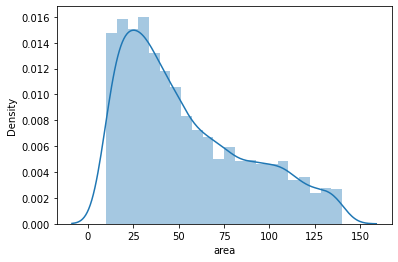

In [8]:
sns.distplot(df_train.area);

In [9]:
df_train['cat_area'] = df_train.area.map(lambda x: x // 10)
df_test['cat_area'] = df_test.area.map(lambda x: x // 10)
df_train = df_train.drop(['area'], axis=1)
df_test = df_test.drop(['area'], axis=1)
df_train

,crop,id,4-15,4-16,4-18,4-19,4-20,4-22,4-23,4-25,4-26,4-27,4-28,4-29,4-30,5-01,5-02,5-03,5-04,5-07,5-08,5-09,5-10,5-15,5-16,5-17,5-19,5-20,5-21,5-24,5-26,5-27,5-29,6-02,6-03,6-04,6-05,6-06,6-07,6-09,6-10,6-12,6-13,6-16,6-18,6-19,6-20,6-22,6-25,6-27,6-28,7-04,7-05,7-07,7-08,7-09,7-13,7-15,7-17,7-20,7-26,7-27,7-29,7-31,8-01,8-07,8-10,8-11,8-12,8-13,8-23,8-27,longitude,latitude,cat_area
0,3,3536,0.187,0.073,0.262,0.262,0.063,0.063,0.000,0.078,0.104,0.000,0.021,0.000,0.000,0.122,0.052,0.084,0.159,0.000,0.009,0.103,0.213,0.358,0.484,0.201,0.426,0.109,0.030,0.081,0.398,0.385,0.016,0.271,0.174,0.119,0.000,0.007,0.112,0.442,0.000,0.039,0.173,0.000,0.412,0.507,0.491,0.550,0.461,0.101,0.155,0.014,0.027,0.707,0.691,0.711,0.731,0.718,0.000,0.147,0.728,0.113,0.728,0.000,0.755,0.000,0.031,0.000,0.658,0.127,0.035,0.615,42.491,51.414,2
1,4,3739,0.245,0.333,0.349,0.287,0.065,0.097,0.025,0.174,0.152,0.196,0.075,0.015,0.242,0.047,0.000,0.000,0.140,0.163,0.113,0.000,0.161,0.031,0.519,0.501,0.249,0.134,0.047,0.047,0.449,0.693,0.628,0.000,0.040,0.208,0.000,0.017,0.708,0.000,0.000,0.150,0.060,0.000,0.492,0.709,0.668,0.676,0.694,0.655,0.433,0.194,0.111,0.709,0.697,0.269,0.077,0.639,0.677,0.461,0.060,0.074,0.667,0.090,0.706,0.184,0.063,0.618,0.602,0.175,0.000,0.180,50.255,56.605,4
2,2,1294,0.006,0.014,0.000,0.007,0.000,0.121,0.112,0.042,0.038,0.169,0.259,0.011,0.118,0.230,0.000,0.025,0.037,0.507,0.007,0.029,0.152,0.003,0.000,0.562,0.128,0.084,0.000,0.220,0.030,0.246,0.650,0.012,0.000,0.000,0.210,0.000,0.056,0.516,0.130,0.012,0.000,0.717,0.649,0.741,0.652,0.740,0.595,0.741,0.172,0.136,0.155,0.648,0.242,0.586,0.551,0.523,0.543,0.000,0.173,0.119,0.322,0.411,0.000,0.357,0.045,0.172,0.000,0.091,0.000,0.054,37.997,53.836,2
3,5,2859,0.293,0.106,0.318,0.053,0.154,0.002,0.045,0.073,0.012,0.000,0.042,0.145,0.008,0.046,0.000,0.063,0.000,0.044,0.328,0.053,0.099,0.412,0.510,0.512,0.528,0.000,0.000,0.587,0.525,0.707,0.645,0.442,0.747,0.642,0.133,0.753,0.009,0.000,0.000,0.100,0.032,0.065,0.544,0.706,0.617,0.713,0.628,0.563,0.230,0.057,0.571,0.591,0.557,0.188,0.466,0.162,0.426,0.095,0.474,0.242,0.000,0.056,0.152,0.061,0.353,0.379,0.327,0.073,0.062,0.379,44.722,55.935,1
4,4,3685,0.028,0.131,0.117,0.063,0.041,0.024,0.164,0.109,0.000,0.022,0.151,0.034,0.081,0.149,0.047,0.047,0.254,0.101,0.054,0.025,0.067,0.002,0.000,0.403,0.000,0.206,0.243,0.018,0.509,0.244,0.085,0.114,0.054,0.099,0.152,0.025,0.240,0.020,0.073,0.022,0.174,0.242,0.583,0.454,0.587,0.573,0.602,0.172,0.087,0.143,0.148,0.752,0.726,0.751,0.767,0.191,0.783,0.518,0.803,0.762,0.834,0.611,0.773,0.000,0.081,0.000,0.055,0.158,0.022,0.012,34.778,52.907,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,6,3772,0.066,0.029,0.000,0.038,0.000,0.255,0.096,0.242,0.148,0.242,0.225,0.149,0.000,0.151,0.479,0.000,0.072,0.017,0.018,0.013,0.149,0.101,0.408,0.367,0.170,0.002,0.054,0.148,0.444,0.076,0.364,0.187,0.152,0.032,0.067,0.000,0.013,0.103,0.139,0.054,0.032,0.028,0.599,0.686,0.701,0.701,0.056,0.672,0.045,0.227,0.009,0.802,0.769,0.802,0.772,0.602,0.687,0.702,0.661,0.624,0.684,0.379,0.701,0.646,0.000,0.059,0.631,0.042,0.119,0.022,40.901,50.905,7
4826,6,5191,0.244,0.036,0.013,0.031,0.247,0.034,0.000,0.022,0.030,0.057,0.318,0.070,0.081,0.044,0.248,0.094,0.265,0.286,0.048,0.075,0.150,0.070,0.579,0.421,0.041,0.192,0.128,0.041,0.550,0.028,0.545,0.167,0.243,0.256,0.131,0.000,0.107,0.177,0.000,0.081,0.163,0.000,0.765,0.805,0.792,0.801,0.763,0.767,0.080,0.000,0.187,0.808,0.845,0.826,0.796,0.716,0.714,0.733,0.756,0.752,0.793,0.801,0.634,0.784,0.094,0.000,0.777,0.056,0.058,0.044,40.009,51.798,10
4827,6,5226,0.090,0.191,0.020,0.064,0.000,0.140,0.144,0.219,0.324,0.003,0.000,0.193,0.000,0.016,0.005,0.024,0.093,0.399,0.051,0.003,0.163,0.000,0.006,0.478,0.022,0.085,0.074,0.080,0.421,0

In [10]:
df_train.cat_area.value_counts()

2     744
1     716
3     677
4     531
5     397
6     346
7     290
10    235
8     227
9     225
11    169
13    138
12    127
14      8
Name: cat_area, dtype: int64

## 2.5. Работа с нулевыми значениями NDVI и выбросами

Превратим в столбцах с индексами NDVI в пропуски (np.nan) не только нулевые значения, но и значения, которые будем считать выбросами. Выбросами будем считать данные в каждой климатической полосе, где средниее значение индекса NDVI выходит отклоняется больее чем на 3/4 стандартного отклонения.

## 2.6. Формирование DUMMY

Получили практически половину пропусков во временных рядах с индексами NDVI, но не будем этому пугаться, возможно были удалены самые "мусорные" данные. Далее произведем группировку оставшихся данных следующим образом:
у нас в данных 70 колонок, соответствующих определенным дням с 15 апреля по 27 августа, так как изменения в ближайшие дни в росте культур не должны быть слишком заметны, рассмотрим интервалы по 7 дням - наблюдениям, и вместо наблюдений этих семи дней поставим одно значение - среднее от всех, имеющихся за эти 7 дней NDVI, таким образом получим таблицу из 10 колонок - периодов, со средними NDVI

## 2.7. Рассмотрим распределение C/Х культур в целевом столбце 

In [11]:
dict_corp = {0: 'подсолнечник',
             1: 'картофель',
             2: 'пшеница озимая',
             3:'гречиха',
             4: 'кукуруза',
             5: 'пшеница яровая',
             6: 'сахарная свекла'} 
df_train['crop_name'] = df_train['crop'].map(lambda x: dict_corp[x])

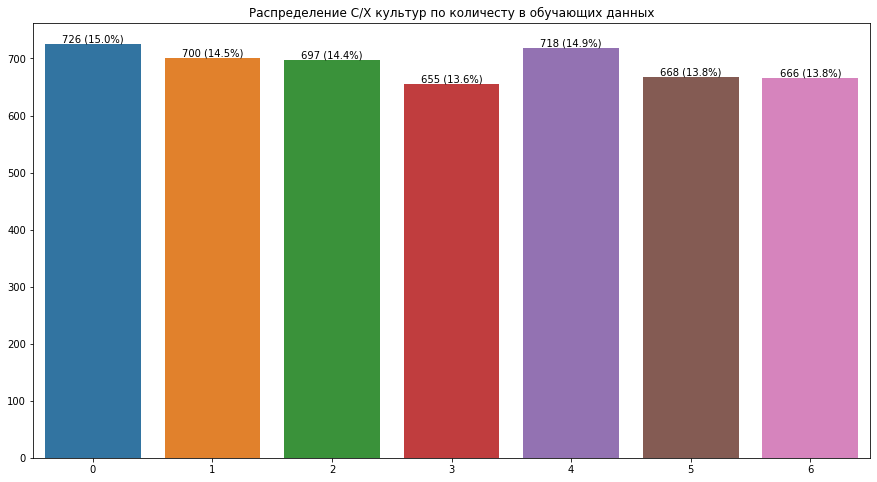

In [12]:
plt.subplots(figsize=(15, 8))
ax = sns.countplot(x=df_train['crop'])
df = pd.DataFrame(df_train['crop'].value_counts())
df['Norm'] = df.crop.map(lambda x: 100 * x / df.crop.sum())
df['Sort'] = df.index
df = df.sort_values(by='Sort')
abs_values = df['crop']
rel_values = df['Norm']
lbls = [f'{p[0]} ({p[1]:.1f}%)' for p in zip(abs_values, rel_values)]
ax.bar_label(container=ax.containers[0], labels=lbls)
plt.setp(ax, xlabel=None, ylabel=None, title='Распределение С/Х культур по количесту в обучающих данных')
plt.show()

Распределение показывает, что дисбаланса классов практически нет.

# 3. Модель

## 3.1. формирование выборок

In [13]:
df_train

,crop,id,4-15,4-16,4-18,4-19,4-20,4-22,4-23,4-25,4-26,4-27,4-28,4-29,4-30,5-01,5-02,5-03,5-04,5-07,5-08,5-09,5-10,5-15,5-16,5-17,5-19,5-20,5-21,5-24,5-26,5-27,5-29,6-02,6-03,6-04,6-05,6-06,6-07,6-09,6-10,6-12,6-13,6-16,6-18,6-19,6-20,6-22,6-25,6-27,6-28,7-04,7-05,7-07,7-08,7-09,7-13,7-15,7-17,7-20,7-26,7-27,7-29,7-31,8-01,8-07,8-10,8-11,8-12,8-13,8-23,8-27,longitude,latitude,cat_area,crop_name
0,3,3536,0.187,0.073,0.262,0.262,0.063,0.063,0.000,0.078,0.104,0.000,0.021,0.000,0.000,0.122,0.052,0.084,0.159,0.000,0.009,0.103,0.213,0.358,0.484,0.201,0.426,0.109,0.030,0.081,0.398,0.385,0.016,0.271,0.174,0.119,0.000,0.007,0.112,0.442,0.000,0.039,0.173,0.000,0.412,0.507,0.491,0.550,0.461,0.101,0.155,0.014,0.027,0.707,0.691,0.711,0.731,0.718,0.000,0.147,0.728,0.113,0.728,0.000,0.755,0.000,0.031,0.000,0.658,0.127,0.035,0.615,42.491,51.414,2,гречиха
1,4,3739,0.245,0.333,0.349,0.287,0.065,0.097,0.025,0.174,0.152,0.196,0.075,0.015,0.242,0.047,0.000,0.000,0.140,0.163,0.113,0.000,0.161,0.031,0.519,0.501,0.249,0.134,0.047,0.047,0.449,0.693,0.628,0.000,0.040,0.208,0.000,0.017,0.708,0.000,0.000,0.150,0.060,0.000,0.492,0.709,0.668,0.676,0.694,0.655,0.433,0.194,0.111,0.709,0.697,0.269,0.077,0.639,0.677,0.461,0.060,0.074,0.667,0.090,0.706,0.184,0.063,0.618,0.602,0.175,0.000,0.180,50.255,56.605,4,кукуруза
2,2,1294,0.006,0.014,0.000,0.007,0.000,0.121,0.112,0.042,0.038,0.169,0.259,0.011,0.118,0.230,0.000,0.025,0.037,0.507,0.007,0.029,0.152,0.003,0.000,0.562,0.128,0.084,0.000,0.220,0.030,0.246,0.650,0.012,0.000,0.000,0.210,0.000,0.056,0.516,0.130,0.012,0.000,0.717,0.649,0.741,0.652,0.740,0.595,0.741,0.172,0.136,0.155,0.648,0.242,0.586,0.551,0.523,0.543,0.000,0.173,0.119,0.322,0.411,0.000,0.357,0.045,0.172,0.000,0.091,0.000,0.054,37.997,53.836,2,пшеница озимая
3,5,2859,0.293,0.106,0.318,0.053,0.154,0.002,0.045,0.073,0.012,0.000,0.042,0.145,0.008,0.046,0.000,0.063,0.000,0.044,0.328,0.053,0.099,0.412,0.510,0.512,0.528,0.000,0.000,0.587,0.525,0.707,0.645,0.442,0.747,0.642,0.133,0.753,0.009,0.000,0.000,0.100,0.032,0.065,0.544,0.706,0.617,0.713,0.628,0.563,0.230,0.057,0.571,0.591,0.557,0.188,0.466,0.162,0.426,0.095,0.474,0.242,0.000,0.056,0.152,0.061,0.353,0.379,0.327,0.073,0.062,0.379,44.722,55.935,1,пшеница яровая
4,4,3685,0.028,0.131,0.117,0.063,0.041,0.024,0.164,0.109,0.000,0.022,0.151,0.034,0.081,0.149,0.047,0.047,0.254,0.101,0.054,0.025,0.067,0.002,0.000,0.403,0.000,0.206,0.243,0.018,0.509,0.244,0.085,0.114,0.054,0.099,0.152,0.025,0.240,0.020,0.073,0.022,0.174,0.242,0.583,0.454,0.587,0.573,0.602,0.172,0.087,0.143,0.148,0.752,0.726,0.751,0.767,0.191,0.783,0.518,0.803,0.762,0.834,0.611,0.773,0.000,0.081,0.000,0.055,0.158,0.022,0.012,34.778,52.907,3,кукуруза
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,6,3772,0.066,0.029,0.000,0.038,0.000,0.255,0.096,0.242,0.148,0.242,0.225,0.149,0.000,0.151,0.479,0.000,0.072,0.017,0.018,0.013,0.149,0.101,0.408,0.367,0.170,0.002,0.054,0.148,0.444,0.076,0.364,0.187,0.152,0.032,0.067,0.000,0.013,0.103,0.139,0.054,0.032,0.028,0.599,0.686,0.701,0.701,0.056,0.672,0.045,0.227,0.009,0.802,0.769,0.802,0.772,0.602,0.687,0.702,0.661,0.624,0.684,0.379,0.701,0.646,0.000,0.059,0.631,0.042,0.119,0.022,40.901,50.905,7,сахарная свекла
4826,6,5191,0.244,0.036,0.013,0.031,0.247,0.034,0.000,0.022,0.030,0.057,0.318,0.070,0.081,0.044,0.248,0.094,0.265,0.286,0.048,0.075,0.150,0.070,0.579,0.421,0.041,0.192,0.128,0.041,0.550,0.028,0.545,0.167,0.243,0.256,0.131,0.000,0.107,0.177,0.000,0.081,0.163,0.000,0.765,0.805,0.792,0.801,0.763,0.767,0.080,0.000,0.187,0.808,0.845,0.826,0.796,0.716,0.714,0.733,0.756,0.752,0.793,0.801,0.634,0.784,0.094,0.000,0.777,0.056,0.058,0.044,40.009,51.798,10,сахарная свекла
4827,6,5226,0.090,0.191,0.020,0.064,0.000,0.140,0.144,0.219,0.324,0.003,0.000,0.193,0

In [14]:
X = df_train.drop(['id', 'crop', 'crop_name'], axis = 1)
y = df_train[['crop']]
X_test = df_test.drop(['id'], axis = 1)

In [15]:
X

,4-15,4-16,4-18,4-19,4-20,4-22,4-23,4-25,4-26,4-27,4-28,4-29,4-30,5-01,5-02,5-03,5-04,5-07,5-08,5-09,5-10,5-15,5-16,5-17,5-19,5-20,5-21,5-24,5-26,5-27,5-29,6-02,6-03,6-04,6-05,6-06,6-07,6-09,6-10,6-12,6-13,6-16,6-18,6-19,6-20,6-22,6-25,6-27,6-28,7-04,7-05,7-07,7-08,7-09,7-13,7-15,7-17,7-20,7-26,7-27,7-29,7-31,8-01,8-07,8-10,8-11,8-12,8-13,8-23,8-27,longitude,latitude,cat_area
0,0.187,0.073,0.262,0.262,0.063,0.063,0.000,0.078,0.104,0.000,0.021,0.000,0.000,0.122,0.052,0.084,0.159,0.000,0.009,0.103,0.213,0.358,0.484,0.201,0.426,0.109,0.030,0.081,0.398,0.385,0.016,0.271,0.174,0.119,0.000,0.007,0.112,0.442,0.000,0.039,0.173,0.000,0.412,0.507,0.491,0.550,0.461,0.101,0.155,0.014,0.027,0.707,0.691,0.711,0.731,0.718,0.000,0.147,0.728,0.113,0.728,0.000,0.755,0.000,0.031,0.000,0.658,0.127,0.035,0.615,42.491,51.414,2
1,0.245,0.333,0.349,0.287,0.065,0.097,0.025,0.174,0.152,0.196,0.075,0.015,0.242,0.047,0.000,0.000,0.140,0.163,0.113,0.000,0.161,0.031,0.519,0.501,0.249,0.134,0.047,0.047,0.449,0.693,0.628,0.000,0.040,0.208,0.000,0.017,0.708,0.000,0.000,0.150,0.060,0.000,0.492,0.709,0.668,0.676,0.694,0.655,0.433,0.194,0.111,0.709,0.697,0.269,0.077,0.639,0.677,0.461,0.060,0.074,0.667,0.090,0.706,0.184,0.063,0.618,0.602,0.175,0.000,0.180,50.255,56.605,4
2,0.006,0.014,0.000,0.007,0.000,0.121,0.112,0.042,0.038,0.169,0.259,0.011,0.118,0.230,0.000,0.025,0.037,0.507,0.007,0.029,0.152,0.003,0.000,0.562,0.128,0.084,0.000,0.220,0.030,0.246,0.650,0.012,0.000,0.000,0.210,0.000,0.056,0.516,0.130,0.012,0.000,0.717,0.649,0.741,0.652,0.740,0.595,0.741,0.172,0.136,0.155,0.648,0.242,0.586,0.551,0.523,0.543,0.000,0.173,0.119,0.322,0.411,0.000,0.357,0.045,0.172,0.000,0.091,0.000,0.054,37.997,53.836,2
3,0.293,0.106,0.318,0.053,0.154,0.002,0.045,0.073,0.012,0.000,0.042,0.145,0.008,0.046,0.000,0.063,0.000,0.044,0.328,0.053,0.099,0.412,0.510,0.512,0.528,0.000,0.000,0.587,0.525,0.707,0.645,0.442,0.747,0.642,0.133,0.753,0.009,0.000,0.000,0.100,0.032,0.065,0.544,0.706,0.617,0.713,0.628,0.563,0.230,0.057,0.571,0.591,0.557,0.188,0.466,0.162,0.426,0.095,0.474,0.242,0.000,0.056,0.152,0.061,0.353,0.379,0.327,0.073,0.062,0.379,44.722,55.935,1
4,0.028,0.131,0.117,0.063,0.041,0.024,0.164,0.109,0.000,0.022,0.151,0.034,0.081,0.149,0.047,0.047,0.254,0.101,0.054,0.025,0.067,0.002,0.000,0.403,0.000,0.206,0.243,0.018,0.509,0.244,0.085,0.114,0.054,0.099,0.152,0.025,0.240,0.020,0.073,0.022,0.174,0.242,0.583,0.454,0.587,0.573,0.602,0.172,0.087,0.143,0.148,0.752,0.726,0.751,0.767,0.191,0.783,0.518,0.803,0.762,0.834,0.611,0.773,0.000,0.081,0.000,0.055,0.158,0.022,0.012,34.778,52.907,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,0.066,0.029,0.000,0.038,0.000,0.255,0.096,0.242,0.148,0.242,0.225,0.149,0.000,0.151,0.479,0.000,0.072,0.017,0.018,0.013,0.149,0.101,0.408,0.367,0.170,0.002,0.054,0.148,0.444,0.076,0.364,0.187,0.152,0.032,0.067,0.000,0.013,0.103,0.139,0.054,0.032,0.028,0.599,0.686,0.701,0.701,0.056,0.672,0.045,0.227,0.009,0.802,0.769,0.802,0.772,0.602,0.687,0.702,0.661,0.624,0.684,0.379,0.701,0.646,0.000,0.059,0.631,0.042,0.119,0.022,40.901,50.905,7
4826,0.244,0.036,0.013,0.031,0.247,0.034,0.000,0.022,0.030,0.057,0.318,0.070,0.081,0.044,0.248,0.094,0.265,0.286,0.048,0.075,0.150,0.070,0.579,0.421,0.041,0.192,0.128,0.041,0.550,0.028,0.545,0.167,0.243,0.256,0.131,0.000,0.107,0.177,0.000,0.081,0.163,0.000,0.765,0.805,0.792,0.801,0.763,0.767,0.080,0.000,0.187,0.808,0.845,0.826,0.796,0.716,0.714,0.733,0.756,0.752,0.793,0.801,0.634,0.784,0.094,0.000,0.777,0.056,0.058,0.044,40.009,51.798,10
4827,0.090,0.191,0.020,0.064,0.000,0.140,0.144,0.219,0.324,0.003,0.000,0.193,0.000,0.016,0.005,0.024,0.093,0.399,0.051,0.003,0.163,0.000,0.006,0.478,0.022,0.085,0.074,0.080,0.421,0.275,0.604,0.000,0.208,0.187,0.143,0.012,0.060,0.034,0.000,0.000,0.032,0

In [16]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y.crop.values)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.9504132231404959,
 1: 0.9857142857142858,
 2: 0.9899569583931134,
 3: 1.0534351145038168,
 4: 0.9610027855153204,
 5: 1.032934131736527,
 6: 1.0360360360360361}

## 3.2. Выбор модели

## 3.2. Кросс-валидация

In [ ]:
%%time
parameters = {'max_depth': [5],
              'learning_rate': [0.1],
              'n_estimators': [150]
              }

CBC_Grid = XGBClassifier(
                   objective="multi:softmax",
                   nthread=-1,
                   predictor="gpu_predictor",
                   tree_method="gpu_hist",
                   
                   )
#CBC_Grid = CatBoostClassifier(verbose=False, loss_function = 'MultiClass') # gpu_hist  exact
Grid_CBC = GridSearchCV(estimator=CBC_Grid, param_grid=parameters, cv=5, scoring='recall_macro', n_jobs=-1)
Grid_CBC.fit(X, y)
print("Результаты подбора гиперпараметров")
print("\n Лучший Recall:\n",Grid_CBC.best_score_)
print("\n Лучшие параметры:\n",Grid_CBC.best_params_)

In [ ]:
XGBC = XGBClassifier(
                   learning_rate=0.1,
                   n_estimators=150,
                   max_depth=5,
                   objective="multi:softmax",
                   nthread=-1,
                                 
                    
                   ) # predictor="gpu_predictor", tree_method="gpu_hist"    


In [ ]:
XGBC.fit(X, y) # обучение модели
pred = XGBC.predict(X_test)

In [28]:
parameters_lgbm = {'max_depth': [-1],
              'learning_rate': [0.1],
              'n_estimators': [160]
              }

LGBM = LGBMClassifier()
Grid_CBC = GridSearchCV(estimator=LGBM, param_grid=parameters_lgbm, cv=5, scoring='recall_macro', n_jobs=-1)
Grid_CBC.fit(X, y)
print("Результаты подбора гиперпараметров")
print("\n Лучший Recall:\n",Grid_CBC.best_score_)
print("\n Лучшие параметры:\n",Grid_CBC.best_params_)

Результаты подбора гиперпараметров

 Лучший Recall:
 0.972398635580479

 Лучшие параметры:
 {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 160}


In [29]:
LGBM = LGBMClassifier(
                      max_depth=-1,
                      learning_rate=0.2,
                      n_estimators=160,
                     )
LGBM.fit(X, y)
pred = LGBM.predict(X_test)

In [31]:
submit = pd.read_csv('sample_solution.csv')
submit.crop = pred
submit.to_csv('submit_cbc.csv', index=False)

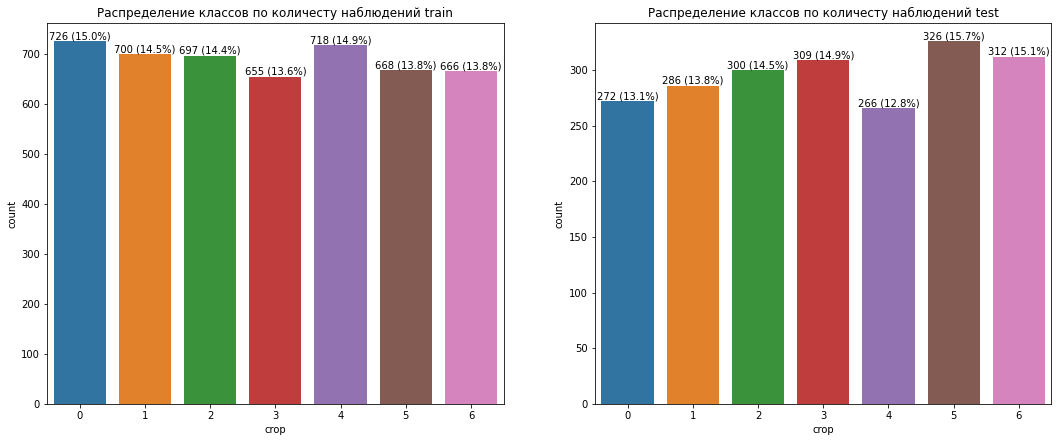

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
for ax, tit in zip(axes, ['Распределение классов по количесту наблюдений train', 'Распределение классов по количесту наблюдений test']):    
    plt.setp(ax, xlabel=None, ylabel=None, title=tit)
for ax, tg in zip(axes, [df_train, submit]):
    sns.countplot(x=tg['crop'], ax=ax)
    df = pd.DataFrame(tg['crop'].value_counts())
    df['Norm'] = df.crop.map(lambda x: 100 * x / df.crop.sum())
    df['Sort'] = df.index
    df = df.sort_values(by='Sort')
    abs_values = df['crop']
    rel_values = df['Norm']
    lbls = [f'{p[0]} ({p[1]:.1f}%)' for p in zip(abs_values, rel_values)]
    ax.bar_label(container=ax.containers[0], labels=lbls)
plt.show()

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, stratify=y, random_state=45)

In [34]:
%%time
LGBM.fit(X_train, y_train)
y_pred_valid = XG.predict(X_valid)
recall_score(y_valid, y_pred_valid, average='macro', zero_division=True)

Wall time: 1.73 s


0.976389100617901

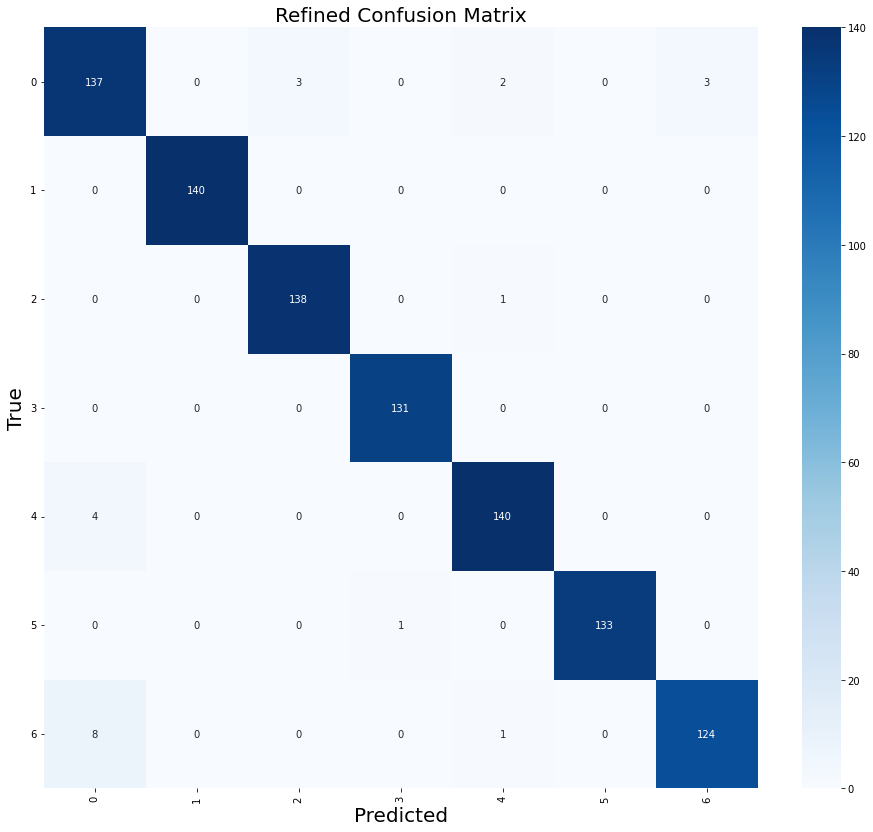

In [35]:
cm = confusion_matrix(y_valid, y_pred_valid)
class_names = sorted(y.crop.unique())
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize=10)
ax.xaxis.tick_bottom()
ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize=10)
plt.yticks(rotation=0)
plt.title('Refined Confusion Matrix', fontsize=20)
plt.show()